# Hierarchical clustering implementation for SOMLib

### import necessary libraries

In [1]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import numpy as np
import matplotlib.pyplot as plt

## Class definition of own hierarchical clustering class

In [2]:
class MyHierarchicalClusteringOnSOMLib:
    """
    MyHierarchicalClusteringOnSOMLib:
        Loads a trained SOM from a SOMLib-UNIT file and 
        performs a hierarchical clustering on it.
        
        The data file can be state directly here as the parameter "filePath" or later on with the load_data(filePath)-function.
        After loading the data, the hierarchical clustering algorithm has to be fitted with fit()-function.
        After the fitting step, the clustered SOM can be visualized with the function show_hier_clust_plot()-function. 
        
        The hierarchical clustering algorithm is from sklearn and has the following parameters:
            n_clusters : int or None, default=2
                The number of clusters to find. It must be None if distance_threshold is not None.

            linkage :{“ward”, “complete”, “average”, “single”}, default=”ward”
                Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.
                    “ward” - ward minimizes the variance of the clusters being merged.
                    “average” - average uses the average of the distances of each observation of the two sets.
                    “complete” - complete or maximum linkage uses the maximum distances between all observations of the two sets.
                    “single” - single uses the minimum of the distances between all observations of the two sets.
                    
            distance_threshold : float, default=None
                The linkage distance threshold above which, clusters will not be merged. If not None, n_clusters must be None and compute_full_tree must be True.
                
            random_state : int, RandomState instance or None (default)
                Determines random number generation for centroid initialization. Use
                an int to make the randomness deterministic.
                See :term:`Glossary <random_state>`.
    """
    
    def __init__(self, n_clusters=2, filePath:str=None, 
                 linkage='ward', distance_threshold=None,
                 random_state=None):
        
        self.hier_clust = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, 
                                                  distance_threshold=distance_threshold)
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.distance_threshold = distance_threshold
        self.random_state = random_state
        
        self.valid_data = False
        self.fitted = False
        self.xdim = 0
        self.ydim = 0
        self.zdim = 0
        self.vec_dim = 0
        self.unit = None
        self.unit_map = None
        self.unit_map_cluster_assignment = None
        self.weight_map = None
        if filePath is not None:
            self.load_files(filePath)
    
    def load_files(self, filePath:str):
        """
        Loads all necessary SOMLib files and created the unit map for the hierarchical fitting process
        :param filePath: path to the SOMLib-UNIT/-MAP/-WGT files (filename extension not necessary) 
        :return: None
        """
        # check filePath isn't already with the file ending
        if filePath.lower().endswith('.unit') or \
            filePath.lower().endswith('.map') or \
            filePath.lower().endswith('.wgt'):
            filePath = ''.join(filePath.split('.')[:-1])
        # load data from the unit file
        self._load_unit_file(filePath)
        #self._load_wgt_file(filePath)
        #self._load_map_file(filePath)
        
        # create unit map only with cells which got points on them
        self._create_unit_map()
        # set check boolean if data is correctly loaded to True
        self.valid_data = True
        # set check boolean if data is correctly fitted to False
        self.fitted = False
        
    def fit(self, weighted=False):
        """
        Fits the hierarchical clustering algorithm to the previously loaded SOMLib files.
        
        Throws exception if SOMLib files are not loaded. 
        :param weighted: boolean, default=False, If True fits the hierarchical clustering algorithm with the weighted cell, this means that more dense cells have a higher weight.
        :return: None 
        """
        if not self.valid_data:
            raise Exception("The data files need to be loaded before fitting the k-means clusters! Use load_files(filePath:str)!")
        if weighted:
            # As the hierarchical clustering algorithm does not have a weighted implementation, we do not offer it
            # But it could be added as a future work.
            raise NotImplemented()
        else:
            # number of point per cell is ignored, each cell that has at least 1 point on it counts the same
            self.unit_map_cluster_assignment = \
                self.hier_clust.fit_predict(self.unit_map)
            
        # set check boolean if data is correctly fitted to True
        self.fitted = True

    def plot_dendrogram(self):
        # Create linkage matrix and then plot the dendrogram
        # create the counts of samples under each node
        counts = np.zeros(self.hier_clust.children_.shape[0])
        n_samples = len(self.hier_clust.labels_)
        for i, merge in enumerate(self.hier_clust.children_):
            current_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    current_count += 1  # leaf node
                else:
                    current_count += counts[child_idx - n_samples]
            counts[i] = current_count
    
        linkage_matrix = np.column_stack([self.hier_clust.children_, range(len(self.hier_clust.children_)),
                                          counts]).astype(float)
    
        # Plot the corresponding dendrogram
        dendrogram(linkage_matrix)
    
    def get_hier_clust_plot(self, grid=True, density=True, link_clusters=True, threshold=0.6):
        if not self.fitted:
            raise Exception("The hierarchical clusters need to be fitted before plotting! Use fit()!")
        plt.figure(figsize=(20,20))
        # gets the default 10 color cycle from pyplot for coloring cluster labels and assigned points in the same color 
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        plt.xlim(0 - 0.5, self.xdim - 0.5)
        plt.ylim(0 - 0.5, self.ydim - 0.5)
        plt.xticks(np.arange(0, self.xdim, 1))
        plt.yticks(np.arange(0, self.ydim, 1))
                
        # colors only a proportion of the cell - proportion is dependent on the ratio between the cell and the cell with the highest density
        max_dense_cell = np.max(self.weight_map)
        for cluster_id in range(self.n_clusters):
            if not density:
                ratio = np.ones(len(self.unit_map))
            else:
                # sqrt is used because x and y axis get muliplied by ratio
                ratio = np.sqrt(1. / max_dense_cell * \
                        self.weight_map[self.unit_map_cluster_assignment == cluster_id])
            for unit_id, unit in \
                enumerate(self.unit_map[self.unit_map_cluster_assignment == cluster_id]):
                plt.fill_between([unit[0] - (0.5 * ratio[unit_id]), 
                                  unit[0] + (0.5 * ratio[unit_id])], 
                                 [unit[1] - (0.5 * ratio[unit_id]), 
                                  unit[1] - (0.5 * ratio[unit_id])], 
                                 [unit[1] + (0.5 * ratio[unit_id]), 
                                  unit[1] + (0.5 * ratio[unit_id])],
                                 color= colors[cluster_id % len(colors)])
        
        # draws the grid
        if grid:
            for v in range(self.xdim):
                plt.plot([v - 0.5, v - 0.5], [0 - 0.5, self.ydim - 0.5], color="black", linewidth=2)
            for h in range(self.ydim):
                plt.plot([0 - 0.5, self.xdim - 0.5], [h - 0.5, h - 0.5], color="black", linewidth=2)
        
        # points are not shown ob the map, just for the legend to see which cluster has which color
        for cluster_id in np.sort(np.unique(self.unit_map_cluster_assignment)):
            plt.plot([-10],[-10],
                     color= colors[cluster_id % len(colors)],
                     label="Cluster {}".format(cluster_id+1))
        
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
        return plt
        
    def _create_unit_map(self):
        """
        Internal method to create the unit map, 
        which is needed for the fitting of the hierarchical clustering algorithm
        :return: None 
        """
        unit_map = []
        weight_map = []
        # create the map with only cells that are non empty
        for cell in self.unit:
            if cell['nr_vec_mapped'] != 0:
                unit_map.append([cell['x'], cell['y'], cell['z']])
                weight_map.append(cell['nr_vec_mapped'])
        self.unit_map = np.array(unit_map)
        self.weight_map = np.array(weight_map)
     
    def _load_unit_file(self, filePath:str):
        """
        Internal Method to load the SOMLib UNIT-file.
        :param filePath: path to the SOMLib UNIT-file without the file extension
        :return: None
        """
        try:
            with open(filePath + '.unit', 'r') as file:
                self.unit = []
                
                x, y, z = -1, -1, -1
                unit_id = ""
                quanterror_unit, quanterror_unit_avg = -1., 0.
                nr_vec_mapped = -1
                mapped_vecs = []
                mapped_vecs_dist = []
                
                for line in file:
                    # skip comments or not needed information
                    if line[0] == '#' or \
                            line.lower().startswith('$type') or \
                            line.lower().startswith('$file_format_version') or \
                            line.lower().startswith('$mapped_vecs\n'):
                        continue
                    # read global constants
                    elif line.lower().startswith('$xdim'):
                        self.xdim = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$ydim'):
                        self.ydim = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$zdim'):
                        self.zdim = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$vec_dim'):
                        self.vec_dim = int(line.strip().split(' ')[-1])
                    # read cell constants 
                    elif line.lower().startswith('$pos_x'):
                        x = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$pos_y'):
                        y = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$pos_z'):
                        z = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$unit_id'):
                        unit_id = line.strip().split(' ')[-1]
                    elif line.lower().startswith('$quanterror_unit'):
                        quanterror_unit = float(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$quanterror_unit_avg'):
                        quanterror_unit_avg = float(line.strip().split(' ')[-1])
                        
                    # a cell is done either if its empty after the number of assigen vectors, or if its not empty after the mapped vector distances
                    elif line.lower().startswith('$nr_vec_mapped'):
                        nr_vec_mapped = int(line.strip().split(' ')[-1])
                        if nr_vec_mapped is 0:
                            self._add_to_unit(unit_id=unit_id, x=x, y=y, z=z, 
                                          quanterror_unit=quanterror_unit, 
                                          quanterror_unit_avg=quanterror_unit_avg, 
                                          nr_vec_mapped=nr_vec_mapped, 
                                          mapped_vecs=mapped_vecs, 
                                          mapped_vecs_dist=mapped_vecs_dist)
                            x, y, z = -1, -1, -1
                            unit_id = ""
                            quanterror_unit, quanterror_unit_avg = -1., 0.
                            nr_vec_mapped = -1
                            mapped_vecs = []
                            mapped_vecs_dist = []
                    elif line.lower().startswith('$mapped_vecs_dist'):
                        mapped_vecs_dist.append(list(map(float, line.strip().split(' ')[1:])))
                        self._add_to_unit(unit_id=unit_id, x=x, y=y, z=z, 
                                          quanterror_unit=quanterror_unit, 
                                          quanterror_unit_avg=quanterror_unit_avg, 
                                          nr_vec_mapped=nr_vec_mapped, 
                                          mapped_vecs=mapped_vecs, 
                                          mapped_vecs_dist=mapped_vecs_dist)
                        x, y, z = -1, -1, -1
                        unit_id = ""
                        quanterror_unit, quanterror_unit_avg = -1., 0.
                        nr_vec_mapped = -1
                        mapped_vecs = []
                        mapped_vecs_dist = []
                    else:
                        # the assigned vertices are not indicated by a line beginning and are a reference to the index
                        mapped_vecs.append(int(line.strip()))
        except OSError:
            raise Exception('File {} couldn\'t be opened'.format(filePath + '.map'))
        
    def _add_to_unit(self, unit_id, x, y, z, quanterror_unit, 
                     quanterror_unit_avg, nr_vec_mapped, mapped_vecs, 
                     mapped_vecs_dist):
        """
        Creates a UNIT with all properties from the SOMLib UNIT-file and adds it to the units-List
        :param unit_id: unit_id of the unit
        :param x: X-coordinate of the unit
        :param y: Y-coordinate of the unit
        :param z: Z-coordinate of the unit
        :param quanterror_unit: Quant error of the unit
        :param quanterror_unit_avg: Average quant error of the unit
        :param nr_vec_mapped: Number of mapped vertices to this unit
        :param mapped_vecs: List of mapped vertices of the unit
        :param mapped_vecs_dist: List of the mapped vertices distance
        :return: None
        """
        self.unit.append({
            'unit_id': unit_id,
            'x': x,
            'y': y, 
            'z': z,
            'quanterror_unit': quanterror_unit,
            'quanterror_unit_avg': quanterror_unit_avg,
            'nr_vec_mapped': nr_vec_mapped,
            'mapped_vecs': mapped_vecs,
            'mapped_vecs_dist': mapped_vecs_dist
        })
    
    def _load_wgt_file(self, filePath:str):
        """
        Loads the SOMLib WGT-file:
        ATTENTION: Currently not implemented!
        :param filePath: path to the SOMLib WGT-file without the file extension
        :return: None
        """
        try:
            with open(filePath + '.wgt', 'r') as file:
                for line in file:
                    if line[0] == '#' or line.lower().startswith('$type'):
                        continue
                    elif line.lower().startswith('$xdim'):
                        self.xdim = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$ydim'):
                        self.ydim = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$zdim'):
                        self.zdim = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$vec_dim'):
                        self.vec_dim = int(line.strip().split(' ')[-1])
                    else:
                        #the rest is not implemented as it is not needed
                        raise NotImplemented()                       
        except OSError:
            raise Exception('File {} couldn\'t be opened'.format(filePath + '.map'))

    def _load_map_file(self, filePath:str):
        """
        Loads the SOMLib MAP-file:
        ATTENTION: Currently not implemented!
        :param filePath: path to the SOMLib MAP-file without the file extension
        :return: None
        """
        try:
            raise NotImplemented()
        except OSError:
            raise Exception('File {} couldn\'t be opened'.format(filePath + '.map'))
    

## Example section

### provide some static variables

In [12]:
path_10clusters = 'data/10clusters/output/10clusters'
path_chainlink = 'data/chainlink/output/chainlink'
path_10clusters_own = 'data/10clusters/output/10clusters_{}_{}_{}_{}_pca'
path_chainlink_own = 'data/chainlink/output/chainlink_{}_{}_{}_{}_pca'

sizes = [(20, 25), (100, 60)]
sigmas = [0.1, 2.3, 10]
learning_rates = [0.01, 0.2, 5]

### 10clusters dataset

In [13]:
clusters_hier_clust = MyHierarchicalClusteringOnSOMLib(n_clusters=10, linkage='single', 
                                                  distance_threshold=None, random_state=42)
clusters_hier_clust.load_files(filePath=path_10clusters)
clusters_hier_clust.fit() 

Exception: File data/10clusters/output/10clusters.map couldn't be opened

In [14]:
clusters_hier_clust.plot_dendrogram()

AttributeError: 'AgglomerativeClustering' object has no attribute 'children_'

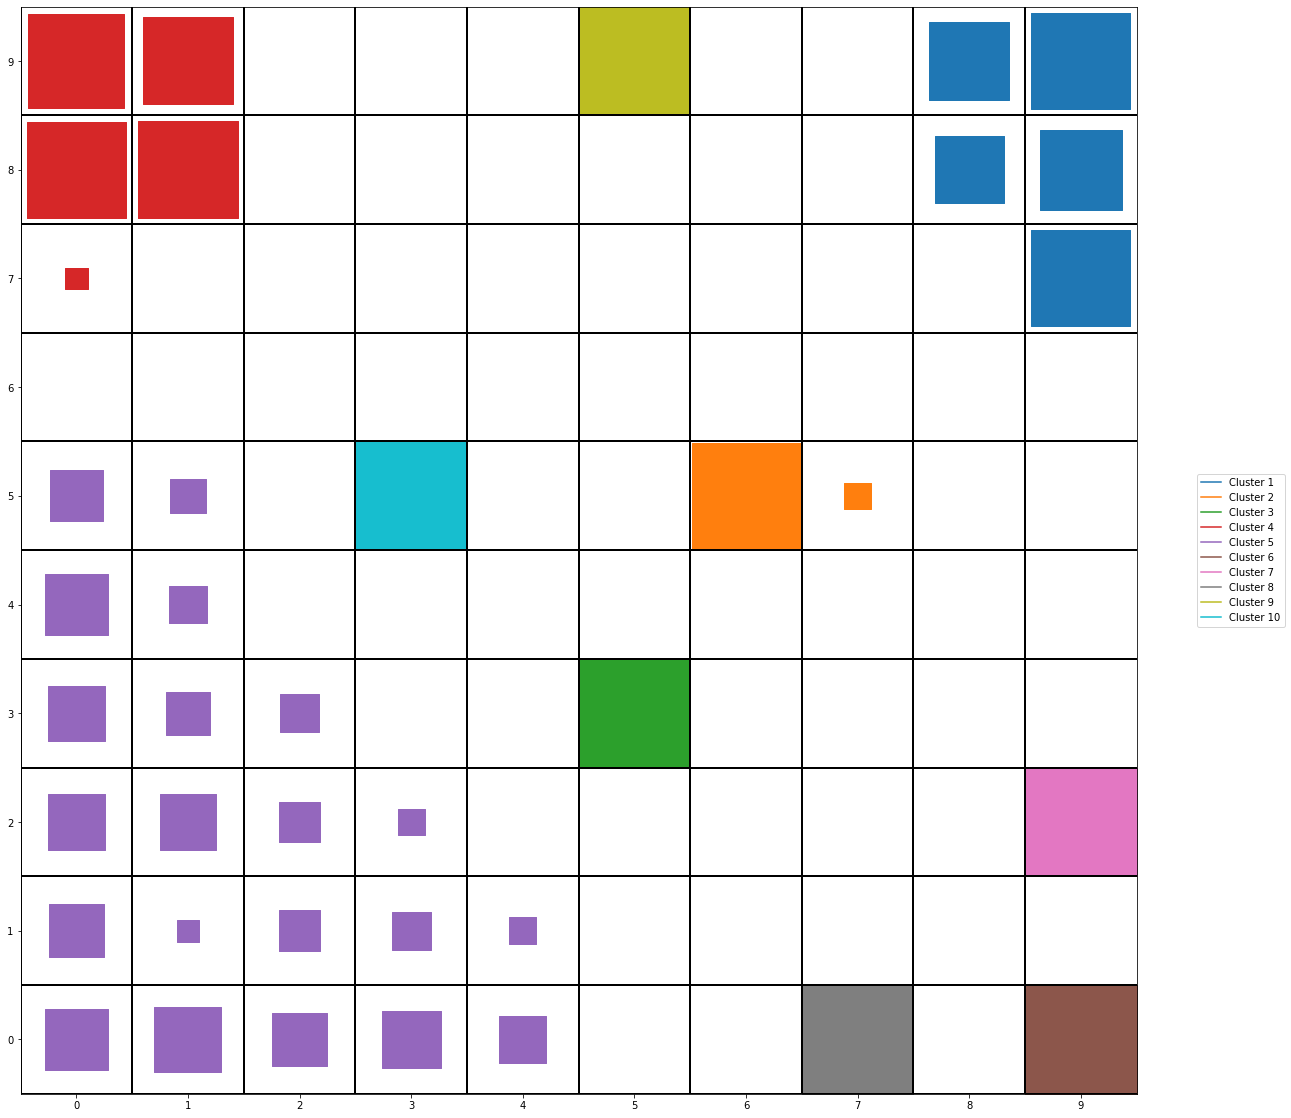

In [8]:
clusters_hier_clust.get_hier_clust_plot(grid=True, density=True, link_clusters=True, threshold=0.7).show()


In [11]:
clusters10_hier_own = MyHierarchicalClusteringOnSOMLib(n_clusters=10, linkage='single', 
                                                  distance_threshold=None, random_state=42)
for (x, y) in sizes:
    for sigma in sigmas:
        for learning_rate in learning_rates:
            clusters10_hier_own.load_files(
                filePath=path_10clusters_own.format(
                    x,
                    y,
                    sigma,
                    learning_rate
                ))
            try:
                clusters10_hier_own.fit()
                clusters10_hier_own.get_hier_clust_plot(title="10CLusters Dataset, sigma {} learn-rate {}".format(sigma, learning_rate),grid=True, density=(x < 40) and (y < 40), link_clusters=False, threshold=1.2)
            except ValueError:
                print("The number of clusters is higher than the number of sampled -> can't be fitted")


Exception: File C:/Users/smola/Desktop/SOM-master/SOM-master/data/10clusters/output/10clusters_20_25_0.1_0.01_pca.map couldn't be opened